## Dependencies

In [1]:
import re
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from time import time

from tqdm import tqdm # progress bar
from sklearn.model_selection import train_test_split # Dividing train test
from nltk.translate.bleu_score import corpus_bleu # BLEU Score

## Dataset
Load dataset from local path or google drive

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [3]:
# Change this path to the dataset downloaded from Flickr8 [5]
dataset_path = "/Users/satyamdoijode/Documents/flicker8k"
dataset_images_path = dataset_path + "/Images/" 

Images configuration

In [4]:
img_height = 180
img_width = 180
validation_split = 0.2

In [5]:
# Remove the last layer of the Inception V3 model
def get_encoder():
    image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    new_input = image_model.input
    hidden_layer = image_model.layers[-1].output

    image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
    return image_features_extract_model

### Read captions
Create dictionary with picture filename as the key and an array of captions as the value

In [6]:
# Preprocess the caption, splitting the string and adding <start> and <end> tokens
def get_preprocessed_caption(caption):    
    caption = re.sub(r'\s+', ' ', caption)
    caption = caption.strip()
    caption = "<start> " + caption + " <end>"
    return caption

In [7]:
images_captions_dict = {}

with open(dataset_path + "/captions.txt", "r") as dataset_info:
    next(dataset_info) # Omit header: image, caption

    # Using a subset of 4,000 entries out of 40,000
    for info_raw in list(dataset_info)[:4000]:
        info = info_raw.split(",")
        image_filename = info[0]
        caption = get_preprocessed_caption(info[1])

        if image_filename not in images_captions_dict.keys():
            images_captions_dict[image_filename] = [caption]
        else:
            images_captions_dict[image_filename].append(caption)

### Read images
Create dictionary with image filename as key and the image feature extracted using the pretrained model as the value.

In [8]:
def load_image(image_path):
    img = tf.io.read_file(dataset_images_path + image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (img_height, img_width))
    img = tf.keras.applications.inception_v3.preprocess_input(img) # preprocessing needed for pre-trained model
    return img, image_path

In [9]:
image_captions_dict_keys = list(images_captions_dict.keys())
image_dataset = tf.data.Dataset.from_tensor_slices(image_captions_dict_keys)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [10]:
images_dict = {}
encoder = get_encoder()
for img_tensor, path_tensor in tqdm(image_dataset):
    batch_features_tensor = encoder(img_tensor)
    
    # Loop over batch to save each element in images_dict
    for batch_features, path in zip(batch_features_tensor, path_tensor):
        decoded_path = path.numpy().decode("utf-8")
        images_dict[decoded_path] = batch_features.numpy()

100%|███████████████████████████████████████████| 13/13 [00:09<00:00,  1.33it/s]


Image size after extracting features from the pre-trained model

In [11]:
list(images_dict.items())[0][1].shape

(4, 4, 2048)

Display image from original dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


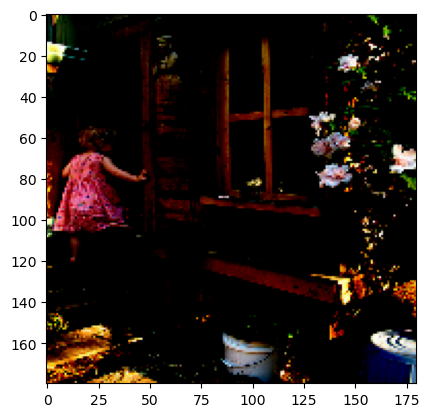

In [12]:
plt.imshow(load_image('1000268201_693b08cb0e.jpg')[0].numpy())

### Get images and labels from filenames

In [13]:
def get_images_labels(image_filenames):
    images = []
    labels = []
    
    for image_filename in image_filenames:
        image = images_dict[image_filename]
        captions = images_captions_dict[image_filename]

        # Add one instance per caption
        for caption in captions:
            images.append(image)
            labels.append(caption)
            
    return images, labels

### Generate train and test set
This approach divides image_filenames, to avoid same image with different caption in train and test dataset. Also the resulting train test is not shuffled because a tensorflow native method will be used for that aim.

In [14]:
image_filenames = list(images_captions_dict.keys())
image_filenames_train, image_filenames_test = \
    train_test_split(image_filenames, test_size=validation_split, random_state=1)

X_train, y_train_raw = get_images_labels(image_filenames_train)
X_test, y_test_raw = get_images_labels(image_filenames_test)

In [15]:
# Per image 5 captions and 0.2 test split
len(X_train), len(y_train_raw), len(X_test), len(y_test_raw)

(3200, 3200, 800, 800)

### Tokenize train labels
Generate a vocabulary and transform the train captions to a vector with their indices in the vocabulary [1].

In [16]:
top_k = 5000 # Take maximum of words out of 7600
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

# Generate vocabulary from train captions
tokenizer.fit_on_texts(y_train_raw)

# Introduce padding to make the captions of the same size for the LSTM model
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
y_train = tokenizer.texts_to_sequences(y_train_raw)

# Add padding to each vector to the max_length of the captions (automatically done)
y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train, padding='post')

Calculate max caption length which would be the number of hidden layers in the LSTM.

In [17]:
max_caption_length = max(len(t) for t in y_train)
print(max_caption_length)

35


Example tokenization

In [18]:
[tokenizer.index_word[i] for i in y_train[1]]

['<start>',
 'a',
 'black',
 'dog',
 'is',
 'standing',
 'on',
 'a',
 'step',
 'next',
 'to',
 'a',
 'river',
 'at',
 'it',
 'shakes',
 'itself',
 'dry',
 '<end>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

### Generate Tensorflow dataset
Generate dataset using buffer and batch size that would be used during training. 

In [19]:
  dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [20]:
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 64
NUM_STEPS = BUFFER_SIZE // BATCH_SIZE

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Using prefetching: https://www.tensorflow.org/guide/data_performance#prefetching
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Models Definition

### CNN Encoder

In [21]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.flat = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(embedding_dim) #, activation='relu')

    def call(self, x):
        x = self.flat(x)
        x = self.fc(x)
        return x

### RNN Decoder

In [22]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        # input_dim = size of the vocabulary
        # Define the embedding layer to transform the input caption sequence
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # Define the Long Short Term Memory layer to predict the next words in the sequence 
        self.lstm = tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True)
            
        # Define a dense layer to transform the LSTM output into prediction of the best word
        self.fc = tf.keras.layers.Dense(vocab_size) #, activation='softmax')

    # A function that transforms the input embeddings and passes them to the LSTM layer 
    def call(self, captions, features, omit_features = False, initial_state = None, verbose = False):
        if verbose:
            print("Before embedding")
            print(captions.shape)

        embed = self.embedding(captions) #(batch_size, 1, embedding_dim)

        if verbose:
            print("Embed")
            print(embed.shape)

        features = tf.expand_dims(features, 1)
        
        if verbose:
            print("Features")
            print(features.shape)
        
        # Concatenating the image and caption embeddings before providing them to LSTM
        # shape == (batch_size, 1, embedding_dim + hidden_size)
        lstm_input = tf.concat([features, embed], axis=-2) if (omit_features == False) else embed
        
        if verbose:
            print("LSTM input")
            print(lstm_input.shape)

        # Passing the concatenated vector to the LSTM
        output, memory_state, carry_state = self.lstm(lstm_input, initial_state=initial_state)

        if verbose:
            print("LSTM output")
            print(output.shape)

        # Transform LSTM output units to vocab_size
        output = self.fc(output)

        return output, memory_state, carry_state

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

## Train Stage

In [23]:
units = embedding_dim = 512 # As in the paper
vocab_size = min(top_k + 1, len(tokenizer.word_index.keys()))

# Initialize encoder and decoder
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

# Initialize optimizer
optimizer = tf.keras.optimizers.Adam()

# As the label is not one-hot encoded but indices. Logits as they are not probabilities.
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# Computes the loss using SCCE and calculates the average of singular losses in the tensor
def loss_function(real, pred, verbose=False):
    loss_ = loss_object(real, pred)
    
    if verbose:
        print("Loss")
        print(loss_)
    
    loss_ = tf.reduce_mean(loss_, axis = 1)
        
    if verbose:
        print("After Mean Axis 1")    
        print(loss_)

    return loss_

In [24]:
# Key Point: Any Python side-effects (appending to a list, printing with print, etc) will only happen once, when func is traced. 
# To have side-effects executed into your tf.function they need to be written as TF ops:
@tf.function
def train_step(img_tensor, target, verbose=False):    
    if verbose:
        print("Image tensor")
        print(img_tensor.shape)

        print("Target")
        print(target.shape)    

    # The input would be each set of words without the last one (<end>), to leave space for the first one that
    # would be the image embedding
    dec_input = tf.convert_to_tensor(target[:, :-1])

    # Source: https://www.tensorflow.org/api_docs/python/tf/GradientTape
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        
        if verbose:
            print("Features CNN")
            print(features)
            
        predictions, _, _ = decoder(dec_input, features, verbose=verbose)        
        
        if verbose:
            print("Predictions RNN")
            print(predictions)
        
        caption_loss = loss_function(target, predictions) # (batch_size, )

        # After tape
        total_batch_loss = tf.reduce_sum(caption_loss) # Sum (batch_size, ) => K
        mean_batch_loss = tf.reduce_mean(caption_loss) # Mean(batch_size, ) => K

    # Updated the variables
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(caption_loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return total_batch_loss, mean_batch_loss

### Checkpoint
Create a tensorflow checkpoint on a local path to save the encoder and decoder state while training. Only the last 5 models would be saved. 

In [25]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [26]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

### Start Training

In [27]:
loss_plot = []

In [28]:
EPOCHS = 5
start_epoch = 0

for epoch in range(start_epoch, EPOCHS):
    real_epoch = len(loss_plot) + 1
    start = time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        total_batch_loss, mean_batch_loss = train_step(img_tensor, target, verbose=False)
        total_loss += total_batch_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Batch Loss {:.4f}'.format(real_epoch, batch, mean_batch_loss.numpy()))
    
    print ('Total Loss {:.6f}'.format(total_loss))
    epoch_loss = total_loss / NUM_STEPS
    
    # storing the epoch end loss value to plot later
    loss_plot.append(epoch_loss)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Epoch Loss {:.6f}'.format(real_epoch, epoch_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time() - start))

Epoch 1 Batch 0 Batch Loss 0.7189
Total Loss 2280.502930
Epoch 1 Epoch Loss 45.610058
Time taken for 1 epoch 13.034528970718384 sec

Epoch 2 Batch 0 Batch Loss 0.7479
Total Loss 2216.007080
Epoch 2 Epoch Loss 44.320141
Time taken for 1 epoch 11.762305974960327 sec

Epoch 3 Batch 0 Batch Loss 0.6269
Total Loss 2150.351318
Epoch 3 Epoch Loss 43.007027
Time taken for 1 epoch 11.889605045318604 sec

Epoch 4 Batch 0 Batch Loss 0.6126
Total Loss 2087.604004
Epoch 4 Epoch Loss 41.752079
Time taken for 1 epoch 11.557976007461548 sec

Epoch 5 Batch 0 Batch Loss 0.6057
Total Loss 2028.533447
Epoch 5 Epoch Loss 40.570667
Time taken for 1 epoch 11.598668813705444 sec



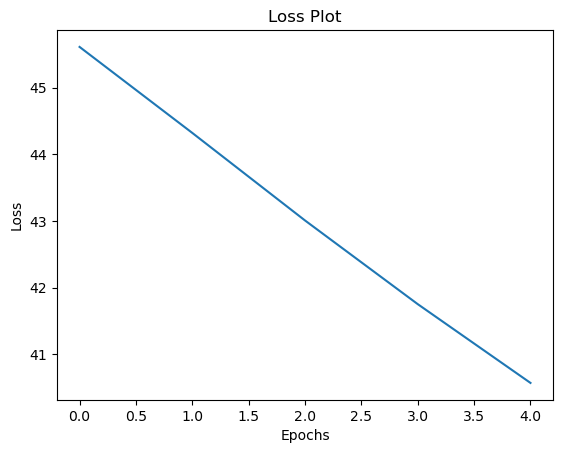

In [29]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Test Stage

### Evaluate random image

In [30]:
# Remove <start>, <end> and <pad> marks from the predicted sequence
def clean_caption(caption):
    return [item for item in caption if item not in ['<start>', '<end>', '<pad>']]

In [31]:
test_img_name = random.choice(image_filenames_train)

Real captions
<start> Two little puppies chase each other on a stone wall . <end>
<start> Two puppies run across flat stones in garden area . <end>
<start> Two puppies walking on stones . <end>
<start> Two small puppies run along the edge of a stone wall nearby a heavily foliaged area . <end>
<start> two small tan puppies walking on a stone path <end>
Esimated caption
['a', 'man', 'in', 'a', 'red', 'shirt', 'and', 'a', 'black', 'shirt', 'is', 'sitting', 'on', 'a', 'rock', 'wall']


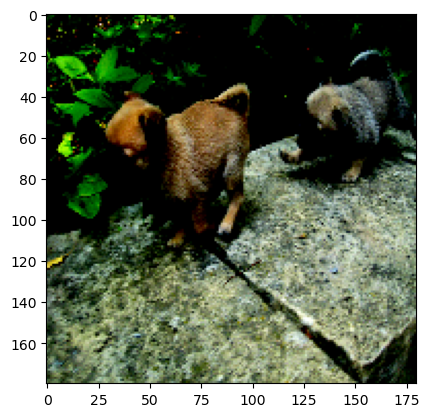

In [32]:
# Get captions from a test image
def get_caption(img):    
    # Add image to an array to simulate batch size of 1    
    features = encoder(tf.expand_dims(img, 0))
    
    caption = []
    dec_input = tf.expand_dims([], 0)
    
     # Inputs the image embedding into the trained LSTM layer and predicts the first word of the sequence.
    # The output, hidden and cell states are passed again to the LSTM to generate the next word.
    # The iteration is repeated until the caption does not reach the max length.
    state = None
    for i in range(1, max_caption_length):
        predictions, memory_state, carry_state = \
            decoder(dec_input, features, omit_features=i > 1, initial_state=state)

        # Takes maximum index of predictions
        word_index = np.argmax(predictions.numpy().flatten())

        caption.append(tokenizer.index_word[word_index])

        dec_input = tf.expand_dims([word_index], 0)       
        state = [memory_state, carry_state]
    
    # Filter caption
    return clean_caption(caption)

raw_img = load_image(test_img_name)[0]
img = images_dict[test_img_name]
captions = images_captions_dict[test_img_name]

plt.imshow(raw_img)

print("Real captions")
for caption in captions:
    print(caption)

print("Esimated caption")
estimated_caption = get_caption(img)
print(estimated_caption)


### Evaluate dataset using BLEU

In [33]:
def get_caption(img):    
    # Add image to an array to simulate batch size of 1    
    features = encoder(tf.expand_dims(img, 0))
    
    caption = []
    dec_input = tf.expand_dims([], 0)
    
    state = None
    for i in range(1, max_caption_length):
        predictions, memory_state, carry_state = \
            decoder(dec_input, features, omit_features=i > 1, initial_state=state)

        word_index = np.argmax(predictions.numpy().flatten())

        caption.append(tokenizer.index_word[word_index])

        dec_input = tf.expand_dims([word_index], 0)       
        state = [memory_state, carry_state]
    
    # Filter caption
    return clean_caption(caption)

actual, predicted = [], []

for test_img_name in image_filenames_test:
    img = images_dict[test_img_name]
    estimated_caption = get_caption(img)

    captions = [clean_caption(caption.split()) for caption in images_captions_dict[test_img_name]]
    
    # store actual and predicted
    actual.append(captions)
    predicted.append(estimated_caption)

# Print BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.344141
BLEU-2: 0.202509


In [34]:
!pip install googletrans==3.1.0a0

In [37]:
from googletrans import Translator
from gtts import gTTS

word_list =  estimated_caption
text_to_say = ' '.join(word_list)
def translate_text(text, target_language):
    translator = Translator()
    translated_text = translator.translate(text, dest=target_language)
    return translated_text.text

# Example usage:
target_language = input("Enter the target language (e.g., fr for French, hi for Hindi, te for Telugu, gu for Gujarat, ka for Kannada,ta for Tamil): ")
text_to_translate = text_to_say

translated_text = translate_text(text_to_translate, target_language)
print(f"Original text: {text_to_translate}")
print(f"Translated text (to {target_language}): {translated_text}")


language="en" #accent
gtts_object=gTTS(text=translated_text, lang=language, slow=False)
gtts_object.save("/Users/satyamdoijode/Desktop/Images/gtts.wav")




Enter the target language (e.g., fr for French, hi for Hindi, te for Telugu, gu for Gujarat, ka for Kannada,ta for Tamil): te
Original text: a man in a red shirt and a black shirt is sitting on a rock wall
Translated text (to te): ఎర్ర చొక్కా మరియు నల్ల చొక్కా ధరించిన ఒక వ్యక్తి రాతి గోడపై కూర్చున్నాడు


In [38]:
from IPython.display import Audio

Audio("/Users/satyamdoijode/Desktop/Images/gtts.wav")